In [312]:
import pandas as pd

In [313]:
df = pd.read_csv("../data/india_fuel_prices_with_locations.csv", index_col=0)

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 698 entries, Adilabad to Zunheboto
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   diesel    698 non-null    float64
 1   petrol    698 non-null    float64
 2   location  698 non-null    object 
 3   lat       698 non-null    float64
 4   lon       698 non-null    float64
dtypes: float64(4), object(1)
memory usage: 32.7+ KB


In [315]:
df.head()

,diesel,petrol,location,lat,lon
Adilabad,99.84,111.83,"Adilabad, Telangana, India",19.500000,78.500000
Agar Malwa,94.89,109.70,"Agar Malwa, Madhya Pradesh, India",23.934296,76.145233
Agra,89.80,96.63,"Agra, Uttar Pradesh, India",27.175255,78.009816
Ahmadnagar,93.03,106.53,"Ahmadnagar, Station Road, माळीवाडा गणपती, Ahme...",19.074352,74.721998
Ahmedabad,92.17,96.42,"Ahmedabad, Ahmedabad City Taluka, Ahmedabad Di...",23.021624,72.579707


## Plots to see the distribution of petrol and diesel prices in India

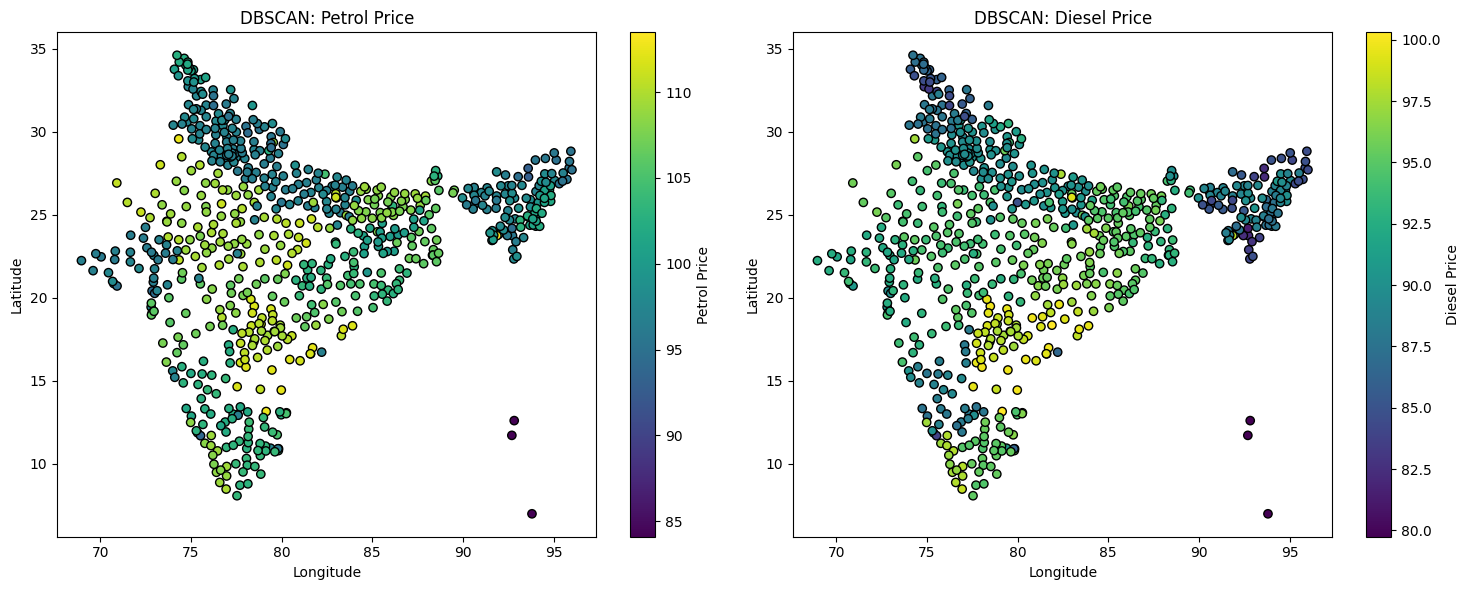

In [316]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter_1 = axes[0].scatter(df["lon"], df["lat"], c=df["petrol"], edgecolors="k")
cbar_1 = plt.colorbar(scatter_1)
cbar_1.set_label("Petrol Price")
axes[0].set_ylabel("Latitude")
axes[0].set_xlabel("Longitude")
axes[0].set_title("DBSCAN: Petrol Price")

scatter_2 = axes[1].scatter(df["lon"], df["lat"], c=df["diesel"], edgecolors="k")
cbar_2 = plt.colorbar(scatter_2)
cbar_2.set_label("Diesel Price")
axes[1].set_ylabel("Latitude")
axes[1].set_xlabel("Longitude")
axes[1].set_title("DBSCAN: Diesel Price")

plt.tight_layout()
plt.show()

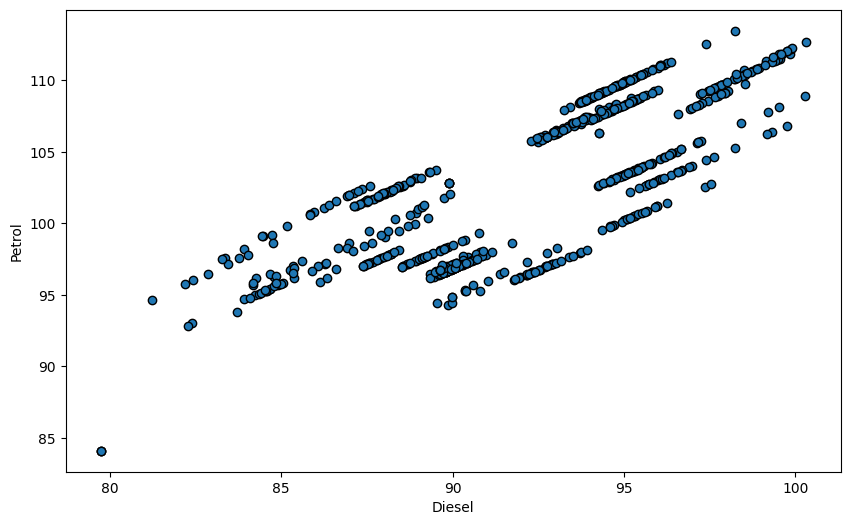

In [317]:
plt.figure(figsize=(10, 6))
plt.scatter(df["diesel"], df["petrol"], edgecolors="k")
plt.ylabel("Petrol")
plt.xlabel("Diesel")
plt.show()

## Scaling the data for DBSCAN algorhytm

- Using knearest to find the distances for the eps value
- 2 * the dimensions (features) for the n_samples

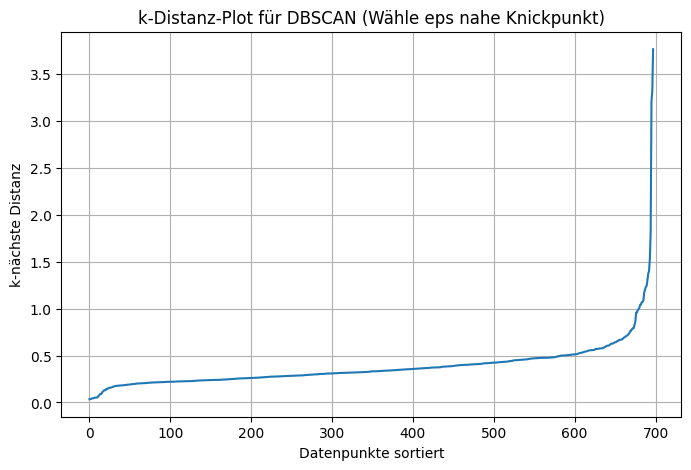

In [318]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[["diesel", "petrol", "lat", "lon"]])
df_scaled = pd.DataFrame(scaled_data, columns=df.drop(columns="location").columns)

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(df_scaled[["diesel", "petrol", "lat", "lon"]])
distances, indices = neighbors_fit.kneighbors(df_scaled[["diesel", "petrol", "lat", "lon"]])

distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Datenpunkte sortiert")
plt.ylabel("k-nächste Distanz")
plt.title("k-Distanz-Plot für DBSCAN (Wähle eps nahe Knickpunkt)")
plt.grid()
plt.show()


Anzahl Cluster: 10


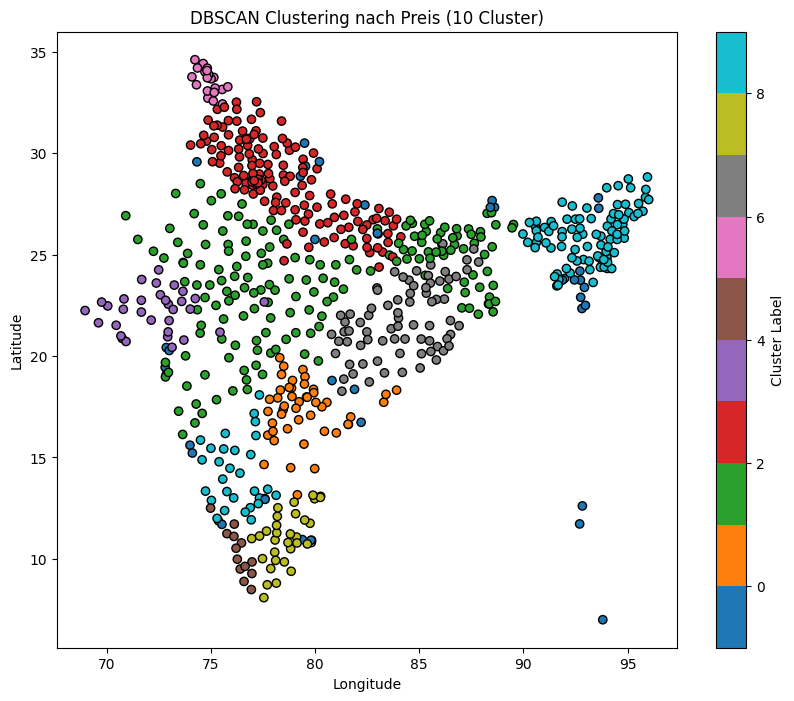

In [319]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=8)
dbscan.fit(df_scaled[["diesel", "petrol", "lat", "lon"]])
labels = dbscan.labels_
df["cluster"] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Anzahl Cluster:", n_clusters)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df["lon"], df["lat"], c=labels, cmap="tab10", edgecolors="k")
plt.colorbar(scatter, label="Cluster Label")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"DBSCAN Clustering nach Preis ({n_clusters} Cluster)")
plt.show()

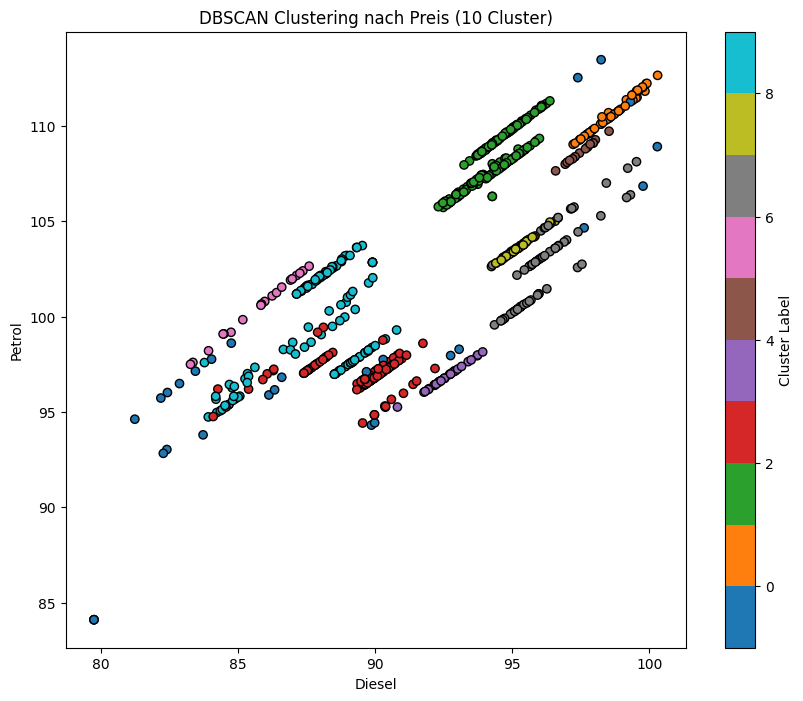

In [322]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df["diesel"], df["petrol"], c=labels, cmap="tab10", edgecolors="k")
plt.colorbar(scatter, label="Cluster Label")
plt.xlabel("Diesel")
plt.ylabel("Petrol")
plt.title(f"DBSCAN Clustering nach Preis ({n_clusters} Cluster)")
plt.show()

In [323]:
cluster_prices = df.groupby("cluster").agg(diesel_min=("diesel", "min"), diesel_max=("diesel", "max"), petrol_min=("petrol", "min"), petrol_max=("petrol", "max"))
cluster_prices.sort_values("diesel_max", ascending=False)

,diesel_min,diesel_max,petrol_min,petrol_max
cluster,,,,
0,96.16,100.30,109.04,112.66
-1,79.74,100.29,84.10,113.48
6,94.28,99.53,99.57,108.13
4,96.58,98.53,107.65,109.73
7,94.24,96.56,102.63,105.01
1,92.30,96.37,105.73,111.32
3,90.81,93.92,95.26,98.15
2,84.09,92.38,94.42,99.44
9,83.77,90.78,94.74,103.21


## Looking deeper into cluster 6 to specify this one more time

,diesel_min,diesel_max,petrol_min,petrol_max
cluster,,,,
6,94.28,99.53,99.57,108.13


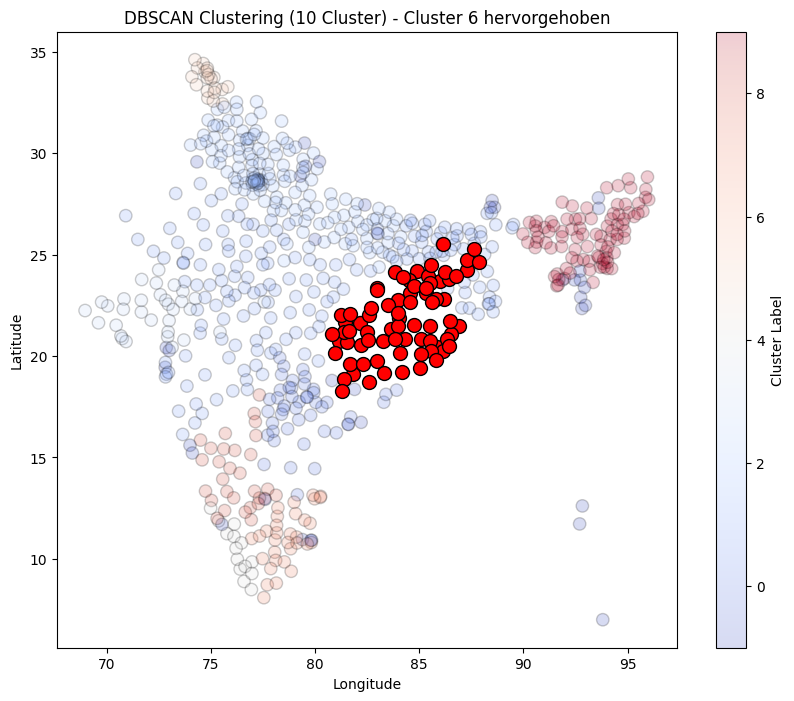

In [326]:
cluster = 6

plt.figure(figsize=(10, 8))
scatter_all = plt.scatter(df["lon"], df["lat"], c=labels, cmap="coolwarm", edgecolors="k", s=80, alpha=0.2)

df_cluster1 = df[labels == cluster]
scatter_c1 = plt.scatter(df_cluster1["lon"], df_cluster1["lat"], color="red", edgecolors="k", s=100, alpha=1.0, label="Cluster 1")

display(cluster_prices[cluster_prices.index == cluster])

plt.colorbar(scatter_all, label="Cluster Label")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"DBSCAN Clustering ({n_clusters} Cluster) - Cluster {cluster} hervorgehoben")
plt.show()

Anzahl Cluster: 3


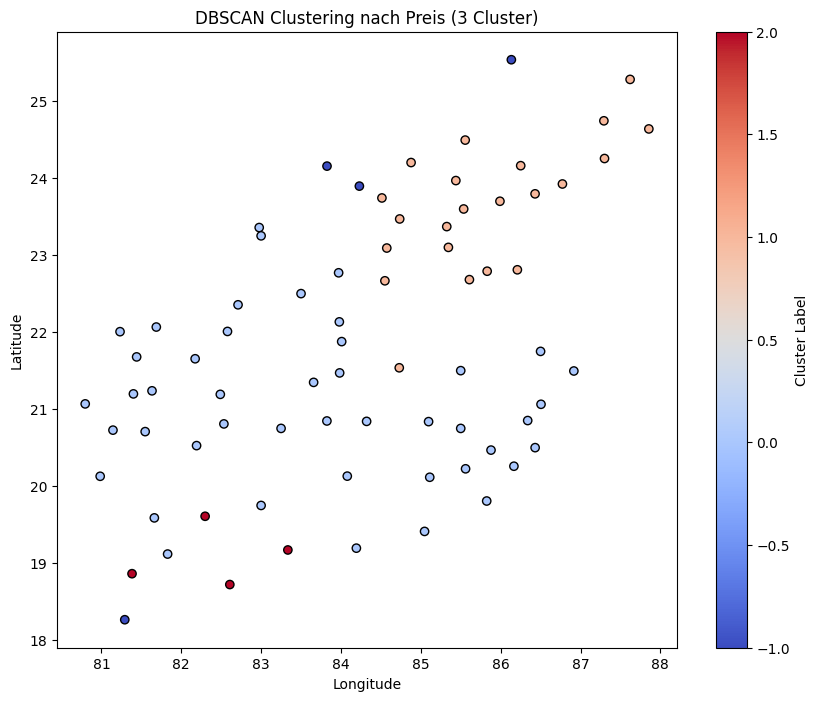

In [342]:
df_cluster_6 = df[df["cluster"] == 6].copy()

scaled_data_cluster_6 = scaler.fit_transform(df_cluster_6[["diesel", "petrol", "lat", "lon"]])


dbscan_refined = DBSCAN(eps=1, min_samples=4)
dbscan_refined.fit(scaled_data_cluster_6)
labels_cluster_6 = dbscan_refined.labels_

df_cluster_6["subcluster"] = labels_cluster_6

n_clusters = len(set(labels_cluster_6)) - (1 if -1 in labels_cluster_6 else 0)
print("Anzahl Cluster:", n_clusters)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_cluster_6["lon"], df_cluster_6["lat"], c=labels_cluster_6, cmap="coolwarm", edgecolors="k")
plt.colorbar(scatter, label="Cluster Label")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"DBSCAN Clustering nach Preis ({n_clusters} Cluster)")
plt.show()